# Forecasting AI and ML Job Trends with SARIMA

At this stage, we handle imballances, train various Text Classification models, and evaluate their performance

## Dependencies

In [1]:
! pip install -q -U imbalanced-learn matplotlib pandas numpy\
    scikit-learn torch transformers datasets accelerate tqdm  \
    gensim evaluate lightgbm 

In [2]:
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm  # Or use tqdm instead of tqdm.notebook

from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    roc_auc_score,
)
from sklearn.preprocessing import label_binarize

import torch

from datasets import Dataset
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from transformers import DataCollatorWithPadding
from transformers import TrainingArguments, Trainer
import evaluate

from gensim.models import KeyedVectors

from sklearn.neural_network import MLPClassifier
from lightgbm import LGBMClassifier

import warnings

In [3]:
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn")

## Data Loading

In [4]:
filename = "data/c_job_postings_dataset_cleaned.parquet"
data = pd.read_parquet(filename)

In [5]:
print(f"{len(data):,} job postings loaded from {filename}")
data.sample(5)

1,296,381 job postings loaded from data/c_job_postings_dataset_cleaned.parquet


,text,label
267416,research technologist biologist roswell park c...,0
804106,volunteer marketing manager haley house manage...,0
144602,quality tech team lead auditor luxottica quali...,0
1129586,restaurant manager bakery supervisor nandos pe...,0
612587,structural steel fitterfabricator electromecha...,0


## Handling Class Imballance

In [6]:
class ImbalanceHandler:
    def __init__(self, data, text_column, label_column):
        self.data = data
        self.text_column = text_column
        self.label_column = label_column

        # Vectorize text data and apply SMOTE
        self.vectorizer = TfidfVectorizer(max_features=5000)
        # Reduce majority class to 35% of the dataset
        self.undersample = RandomUnderSampler(sampling_strategy=0.35, random_state=42)
        # Oversample minority class using SMOTE
        self.smote = SMOTE(random_state=42)
        self.pipeline = Pipeline(
            [
                ("tfidf", self.vectorizer),
                ("undersample", self.undersample),
                ("smote", self.smote),
            ]
        )

    def handle_imbalance(self):
        # Extract features and labels
        X = self.data[self.text_column]
        y = self.data[self.label_column]

        # Apply the pipeline
        print("Handling imbalance...")
        for _ in tqdm(range(1), desc="Resampling"):
            X_res, y_res = self.pipeline.fit_resample(X, y)

        # Include the original text and resampled labels
        print("Creating resampled dataset...")
        resampled_data = pd.DataFrame({self.text_column: X.loc[y_res.index], self.label_column: y_res})
        
        print('Completed handling class imbalance')

        return X_res, y_res, resampled_data

In [7]:
def plot_class_distribution(cleaned_data, y_resampled):
    _, axes = plt.subplots(1, 2, figsize=(16, 5))

    # Visualize the class imbalance before handling
    cleaned_data['label'].value_counts().plot(kind='bar', ax=axes[0], color='skyblue')
    axes[0].set_title('Class Distribution Before Handling Imbalance')
    axes[0].set_xlabel('Class')
    axes[0].set_ylabel('Frequency')

    # Visualize the class distribution after handling imbalance
    pd.Series(y_resampled).value_counts().plot(kind='bar', ax=axes[1], color='salmon')
    axes[1].set_title('Class Distribution After Handling Imbalance')
    axes[1].set_xlabel('Class')
    axes[1].set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

Handling imbalance...


Resampling:   0%|          | 0/1 [00:00<?, ?it/s]

Creating resampled dataset...
Completed handling class imbalance
Original dataset shape: Counter({0: 1274405, 1: 21976})
Resampled dataset shape: Counter({0: 62788, 1: 62788})


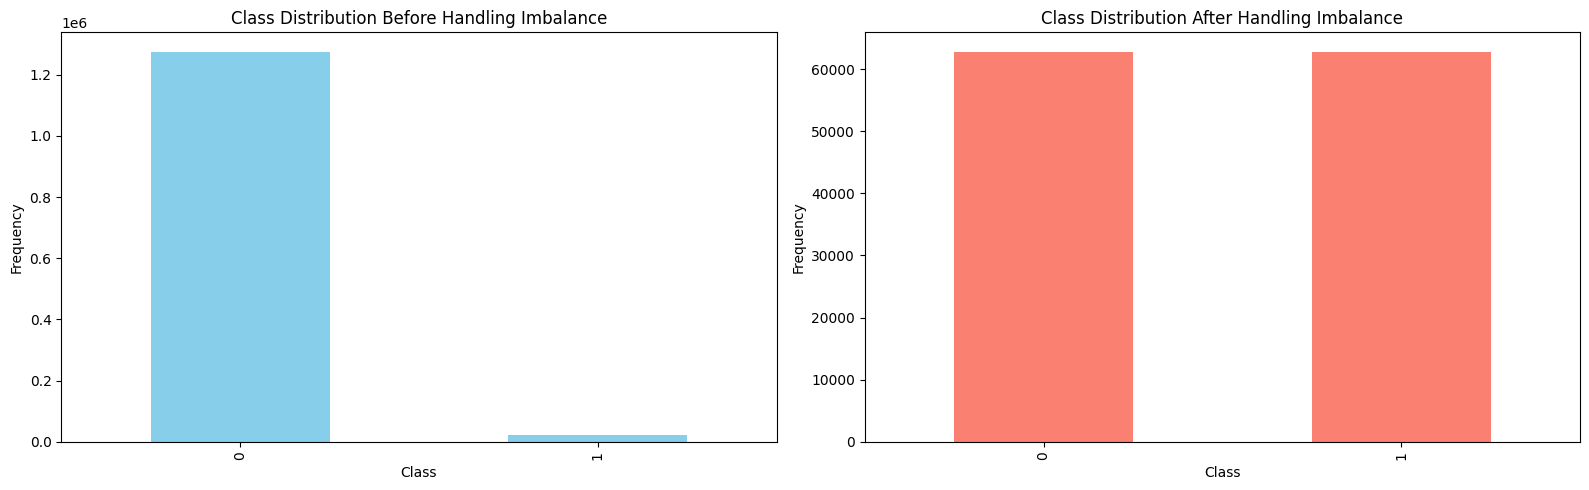

In [8]:
imbalanceHandler = ImbalanceHandler(data, 'text', 'label')
X_res, y_res, resampled_data = imbalanceHandler.handle_imbalance()


# Check the distribution of the new dataset
print(f"Original dataset shape: {Counter(data['label'])}")
print(f"Resampled dataset shape: {Counter(y_res)}")

plot_class_distribution(data, y_res)

## Training Utils

Label Encoder

In [9]:
le = preprocessing.LabelEncoder()
le.fit(resampled_data['label'].tolist())
y = le.transform(resampled_data['label'].tolist())
resampled_data['label'] = y

print(f"Classes: {le.classes_}")

Classes: [0 1]


Model performance evaluation

In [10]:
def evaluate_model(y_true, y_pred, y_pred_proba, le):
    print(classification_report(y_true, y_pred))

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)

    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = roc_auc_score(y_true, y_pred_proba)

    _, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Plot confusion matrix
    disp.plot(cmap='Blues', xticks_rotation=45, ax=axes[0])
    axes[0].set_title('Confusion Matrix')

    # Plot ROC curve
    axes[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    axes[1].set_xlim([0.0, 1.0])
    axes[1].set_ylim([0.0, 1.05])
    axes[1].set_xlabel('False Positive Rate')
    axes[1].set_ylabel('True Positive Rate')
    axes[1].set_title('Receiver Operating Characteristic (ROC) Curve')
    axes[1].legend(loc='lower right')

    plt.tight_layout()
    plt.show()

## Random Forest Classifier

Split the resampled data

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X_res, y_res, test_size=0.25, random_state=42
)

Train the model

In [12]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

Use the model to make predictions

In [13]:
y_pred = rf_model.predict(X_test)
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]

              precision    recall  f1-score   support

           0       0.99      0.97      0.98     15731
           1       0.97      0.99      0.98     15663

    accuracy                           0.98     31394
   macro avg       0.98      0.98      0.98     31394
weighted avg       0.98      0.98      0.98     31394



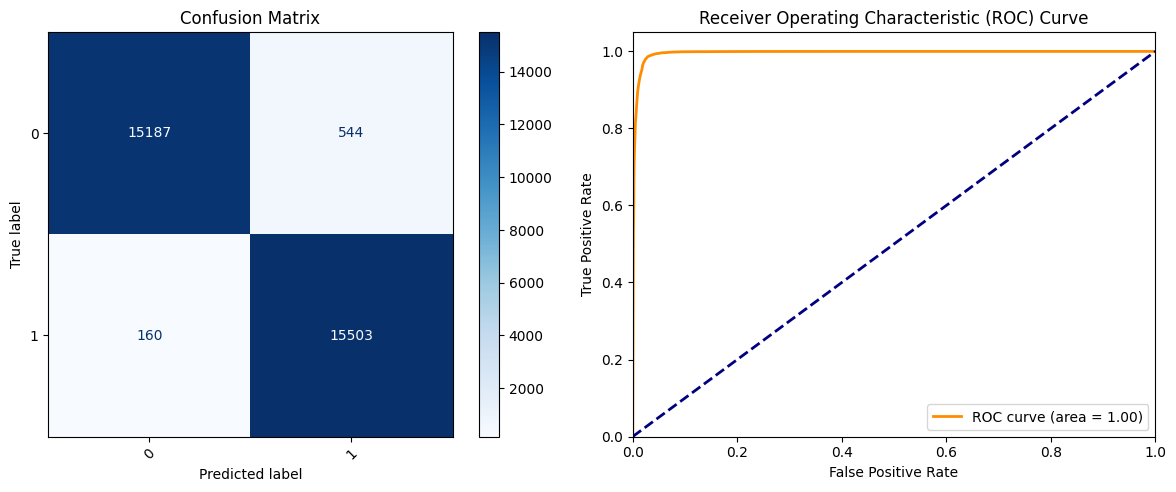

In [14]:
evaluate_model(y_test, y_pred, y_pred_proba, le)

**Highlights:**
- At 98% accuracy, the model performs very well overall.
- Balanced Performance: Precision, recall, and F1-scores are all high and similar across both classes.
- Strong Class Distribution Handling: Despite potential class imbalance (similar but not identical support for 0 and 1), the model handles both classes effectively.
- The AUC is approximately 1.00, indicating excellent performance. 
- The curve's shape and position near the top-left corner further emphasize the model's strong predictive power.

##  Pretrained TinyBERT Model

In [15]:
model_name = "prajjwal1/bert-tiny"
device = torch.device("cpu")

#### Dataset Preparation

Convert to Huggingface Dataset

In [16]:
df_train, df_test = train_test_split(resampled_data, test_size=0.25, random_state=42)

train_dataset = Dataset.from_pandas(df_train)
test_dataset = Dataset.from_pandas(df_test)

train_dataset = train_dataset.with_format("torch")
test_dataset = test_dataset.with_format("torch")

In [17]:
train_dataset.shape, test_dataset.shape

((94182, 3), (31394, 3))

#### Tokenizer

In [18]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

def preprocess_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=512)

tokenized_train = train_dataset.map(preprocess_function, batched=True)
tokenized_test = test_dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/94182 [00:00<?, ? examples/s]

Map:   0%|          | 0/31394 [00:00<?, ? examples/s]

Initialize Model

In [19]:
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)
model.to(device)
print(f"Training model on {device}")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training model on cpu


#### Model Training

In [20]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [21]:
training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-4,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    num_train_epochs=10,
    weight_decay=0.01,
    eval_strategy="epoch",
    logging_strategy="epoch",
    save_strategy="epoch",
    gradient_accumulation_steps=4,  # Simulate larger batch size
    dataloader_num_workers=2  # Optimize dataloader performance
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

In [22]:
trainer.train()
trainer.save_model("ai_ml_job_classiffier")

  0%|          | 0/117720 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


{'loss': 0.6953, 'grad_norm': 9.174723625183105, 'learning_rate': 0.00018, 'epoch': 1.0}


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/15697 [00:00<?, ?it/s]

{'eval_loss': 0.6926647424697876, 'eval_accuracy': 0.5122953430591832, 'eval_runtime': 229.7725, 'eval_samples_per_second': 136.631, 'eval_steps_per_second': 68.315, 'epoch': 1.0}


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


{'loss': 0.694, 'grad_norm': 11.8246488571167, 'learning_rate': 0.00016, 'epoch': 2.0}


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/15697 [00:00<?, ?it/s]

{'eval_loss': 0.695088267326355, 'eval_accuracy': 0.49891699050774035, 'eval_runtime': 226.5228, 'eval_samples_per_second': 138.591, 'eval_steps_per_second': 69.295, 'epoch': 2.0}


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


{'loss': 0.693, 'grad_norm': 7.720426082611084, 'learning_rate': 0.00014, 'epoch': 3.0}


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/15697 [00:00<?, ?it/s]

{'eval_loss': 0.6927967071533203, 'eval_accuracy': 0.5163725552653373, 'eval_runtime': 246.2215, 'eval_samples_per_second': 127.503, 'eval_steps_per_second': 63.752, 'epoch': 3.0}


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


{'loss': 0.6912, 'grad_norm': 18.828275680541992, 'learning_rate': 0.00012, 'epoch': 4.0}


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/15697 [00:00<?, ?it/s]

{'eval_loss': 0.6937947273254395, 'eval_accuracy': 0.5163725552653373, 'eval_runtime': 247.302, 'eval_samples_per_second': 126.946, 'eval_steps_per_second': 63.473, 'epoch': 4.0}


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


{'loss': 0.6894, 'grad_norm': 7.185069561004639, 'learning_rate': 0.0001, 'epoch': 5.0}


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/15697 [00:00<?, ?it/s]

{'eval_loss': 0.6935216188430786, 'eval_accuracy': 0.5232209976428617, 'eval_runtime': 242.5653, 'eval_samples_per_second': 129.425, 'eval_steps_per_second': 64.712, 'epoch': 5.0}


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


{'loss': 0.6862, 'grad_norm': 10.81049919128418, 'learning_rate': 8e-05, 'epoch': 6.0}


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/15697 [00:00<?, ?it/s]

{'eval_loss': 0.699300229549408, 'eval_accuracy': 0.5233802637446646, 'eval_runtime': 224.8113, 'eval_samples_per_second': 139.646, 'eval_steps_per_second': 69.823, 'epoch': 6.0}


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


{'loss': 0.6817, 'grad_norm': 20.571651458740234, 'learning_rate': 6e-05, 'epoch': 7.0}


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/15697 [00:00<?, ?it/s]

{'eval_loss': 0.6972851157188416, 'eval_accuracy': 0.5218513091673568, 'eval_runtime': 225.3923, 'eval_samples_per_second': 139.286, 'eval_steps_per_second': 69.643, 'epoch': 7.0}


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


{'loss': 0.6769, 'grad_norm': 16.511667251586914, 'learning_rate': 4e-05, 'epoch': 8.0}


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/15697 [00:00<?, ?it/s]

{'eval_loss': 0.7006399035453796, 'eval_accuracy': 0.5246225393387272, 'eval_runtime': 234.0832, 'eval_samples_per_second': 134.115, 'eval_steps_per_second': 67.057, 'epoch': 8.0}


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


{'loss': 0.6724, 'grad_norm': 11.835393905639648, 'learning_rate': 2e-05, 'epoch': 9.0}


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/15697 [00:00<?, ?it/s]

{'eval_loss': 0.7096250057220459, 'eval_accuracy': 0.5270115308657706, 'eval_runtime': 226.3701, 'eval_samples_per_second': 138.684, 'eval_steps_per_second': 69.342, 'epoch': 9.0}


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


{'loss': 0.6683, 'grad_norm': 11.082831382751465, 'learning_rate': 0.0, 'epoch': 10.0}


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/15697 [00:00<?, ?it/s]

{'eval_loss': 0.711440920829773, 'eval_accuracy': 0.5283812193412754, 'eval_runtime': 235.3509, 'eval_samples_per_second': 133.392, 'eval_steps_per_second': 66.696, 'epoch': 10.0}
{'train_runtime': 12826.6932, 'train_samples_per_second': 73.427, 'train_steps_per_second': 9.178, 'train_loss': 0.684843238988702, 'epoch': 10.0}


Plot the training loss and accuracy

In [34]:
def plot_training_logs(trainer):
    # Extract training logs
    training_logs = trainer.state.log_history

    # Extract loss and accuracy
    train_loss = [log['loss'] for log in training_logs if 'loss' in log]
    eval_loss = [log['eval_loss'] for log in training_logs if 'eval_loss' in log]
    accuracy = [log['eval_accuracy'] for log in training_logs if 'eval_accuracy' in log]
    steps = [log['step'] for log in training_logs if 'step' in log]

    # Ensure all lists have the same length
    min_length = min(len(train_loss), len(eval_loss), len(accuracy), len(steps))
    train_loss = train_loss[:min_length]
    eval_loss = eval_loss[:min_length]
    accuracy = accuracy[:min_length]
    steps = steps[:min_length]

    # Plot training loss and accuracy side by side
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Plot training loss
    ax1.plot(steps, train_loss, label='Training Loss')
    ax1.plot(steps, eval_loss, label='Evaluation Loss')
    ax1.set_xlabel('Steps')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Evaluation Loss')
    ax1.legend()

    # Plot accuracy
    ax2.plot(steps, accuracy, label='Accuracy')
    ax2.set_xlabel('Steps')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Evaluation Accuracy')
    ax2.legend()

    plt.tight_layout()
    plt.show()

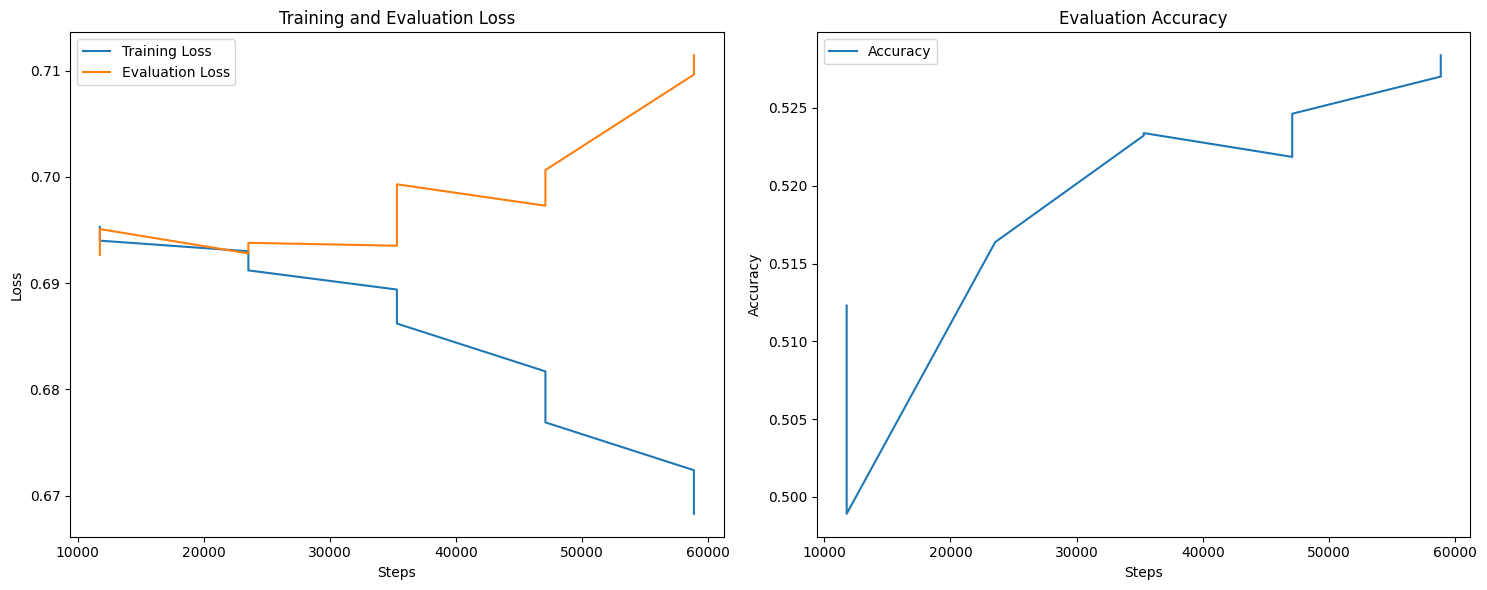

In [35]:
plot_training_logs(trainer)

### Model Evaluation

Evaluate on the training set

In [23]:
preds_bert_train = trainer.predict(tokenized_train)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/47091 [00:00<?, ?it/s]

In [24]:
y_pred_bert_train = np.argmax(preds_bert_train.predictions, axis=-1)
ground_truth = tokenized_train['label'].tolist()

print("Training metrics")
print(classification_report(ground_truth, y_pred_bert_train))

Training metrics
              precision    recall  f1-score   support

           0       0.63      0.51      0.56     47057
           1       0.59      0.70      0.64     47125

    accuracy                           0.60     94182
   macro avg       0.61      0.60      0.60     94182
weighted avg       0.61      0.60      0.60     94182



In [25]:
preds_bert = trainer.predict(tokenized_test)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/15697 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.54      0.43      0.48     15731
           1       0.52      0.63      0.57     15663

    accuracy                           0.53     31394
   macro avg       0.53      0.53      0.52     31394
weighted avg       0.53      0.53      0.52     31394



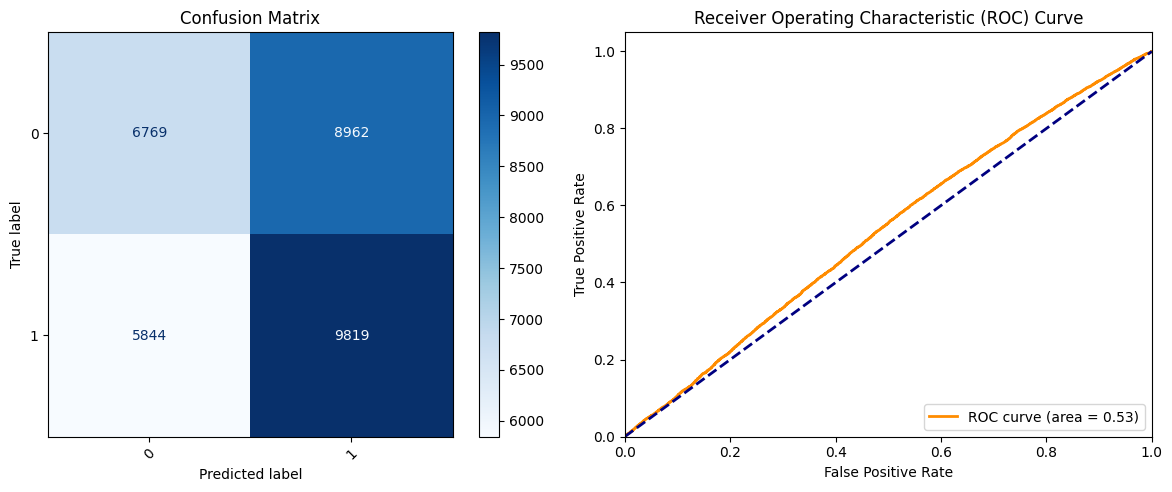

In [26]:
y_pred_bert = np.argmax(preds_bert.predictions, axis=1)
y_pred_proba_bert = preds_bert.predictions[:, 1]
y_true_bert = tokenized_test['label'].tolist()

evaluate_model(y_true_bert, y_pred_bert, y_pred_proba_bert, le)

## Pre-trained Word2Vec model

 #### Embeddings 
 Convert text data to Word2Vec embeddings

In [27]:
class Word2VecHandler:
    def __init__(self, model_path, resampled_data):
        self.model = KeyedVectors.load_word2vec_format(model_path, binary=True)
        self.resampled_data = resampled_data
        self.vector_size = self.model.vector_size

    def text_to_embedding(self, text):
        words = text.split()
        embedding = np.zeros(self.vector_size)
        valid_words = 0
        for word in words:
            if word in self.model:
                embedding += self.model[word]
                valid_words += 1
        if valid_words > 0:
            embedding /= valid_words
        return embedding

    def convert_text_to_embeddings(self):
        embeddings = self.resampled_data["text"].apply(
            lambda x: self.text_to_embedding(x)
        )
        return np.vstack(embeddings)

    def get_embeddings_and_labels(self):
        X = self.convert_text_to_embeddings()
        y = self.resampled_data["label"]
        return X, y

In [28]:
model_path = "/Users/mzitoh/Desktop/word2vec/GoogleNews-vectors-negative300.bin"

word2vec_handler = Word2VecHandler(model_path, resampled_data)
X_w, y_w = word2vec_handler.get_embeddings_and_labels()

In [29]:
X_w.shape, y_w.shape

((125576, 300), (125576,))

In [30]:
X_train_lg, X_test_lg, y_train_lg, y_test_lg = train_test_split(
    X_w,
    y_w,
    test_size=0.2,
    random_state=42,
)

### Training

In [31]:
lgbm_model = LGBMClassifier(random_state=42)
lgbm_model.fit(X_train_lg, y_train_lg)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


[LightGBM] [Info] Number of positive: 50270, number of negative: 50190
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059718 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 76500
[LightGBM] [Info] Number of data points in the train set: 100460, number of used features: 300
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500398 -> initscore=0.001593
[LightGBM] [Info] Start training from score 0.001593


LGBMClassifier(random_state=42)

#### Model Evaluation

In [32]:
y_pred_lg = lgbm_model.predict(X_test_lg)
y_pred_proba_lg = lgbm_model.predict_proba(X_test_lg)[:, 1]

              precision    recall  f1-score   support

           0       0.52      0.45      0.49     12598
           1       0.51      0.58      0.54     12518

    accuracy                           0.52     25116
   macro avg       0.52      0.52      0.52     25116
weighted avg       0.52      0.52      0.52     25116



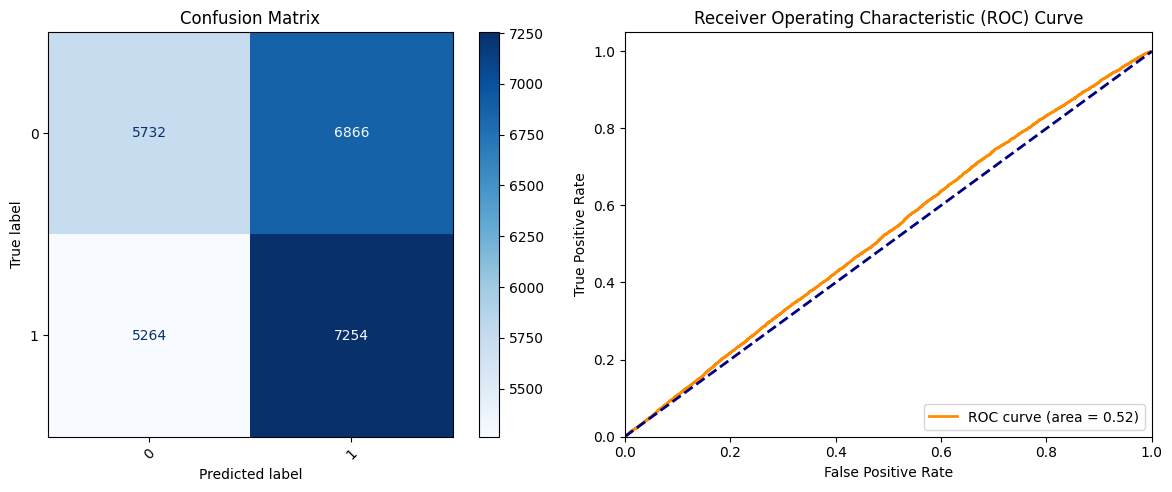

In [33]:
evaluate_model(y_test_lg, y_pred_lg, y_pred_proba_lg, le)